In [1]:
# Import required dependencies
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd

# Add the parent directory to sys.path
parent_dir = os.path.abspath("..")
sys.path.insert(0, parent_dir)

# Import custom modules
import packer
import evaluator

# create instances
GPU_TYPES = ["DGX-B300", "H200", "Rubin-NVL144", "H800", "H20"]
packer = packer.Packer(GPU_TYPES, gpu_info_file='../device/gpu_info.csv')

# define trace pdf evaluator
trace_pdf = evaluator.load_trace_pdf("../traces/generated_trace_pdf.csv")

# Configure matplotlib
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# constants
FIGURE_SAVE_LOCATION = "../data/figures/05evaluate/"
FIGURE_PREFILE = "inner_res_"

In [ ]:
# define test inventories
inventory = {
    "name": "heterogeneous-different",
    "title": "(d) Heterogeneous Different Sizes",
    "GPUs": {
        "DGX-B300": [32, 16, 8, 4, 4],
        "Rubin-NVL144": [32, 16, 8, 4, 4],
        "H200": [8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4],
        "H20": [8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4],
    }
}

resolutions = [50, 100, 200, 400, 800, 1600]

# extract islands from the inventory
island_config = inventory["GPUs"]

# create islands based on the configuration
islands = []
for gpu_type, sizes in island_config.items():
    for idx, size in enumerate(sizes):
        new_island = evaluator.Island(
            id=f"{gpu_type}_{idx}",
            gpu_type=gpu_type,
            size=size,
        )
        islands.append(new_island)
islands = {island.id: island for island in islands}

# print the islands for debugging
print(f"Islands for inventory {inventory['name']}:")
for island in islands.values():
    print(f"  {island.id}: {island.gpu_type} with size {island.size}")
print("")

# sum up the total number of GPUs
total_gpus = sum(island.size for island in islands.values())
print(f"Total GPUs in inventory {inventory['name']}: {total_gpus}")

# pack the GPU
for resolution in resolutions:
    print(f"Packing inventory: {inventory['name']} with resolution {resolution}")
    model, prefill_throughput, decode_throughput, delta, objective = packer.solve_linear(islands, trace_pdf, resolution=resolution, print_debug=False)

    if prefill_throughput is None or decode_throughput is None:
        exit(1)
    else:
        overall_throughput = min(prefill_throughput, decode_throughput)

    # check if the model is not None
    if model is not None:
        # save the model
        packer.save_model(model, islands, f"eval_{inventory['name']}_res_{resolution}", path="../data/inner")

        # add the bins to the islands
        new_islands = packer.add_bins_to_islands(model, islands)

        # pass to evaluator
        sys_evaluator = evaluator.Evaluator(GPU_TYPES, gpu_info_file='../device/gpu_info.csv')
        prefill_throughput, decode_throughput = sys_evaluator.evaluate(new_islands, trace_pdf, f"eval_{inventory['name']}_res_{resolution}", print_debug=False, path="../data/inner")


Number of islands in inventory heterogeneous-different: 34
Number of islands in inventory heterogeneous-different: 34
Number of islands in inventory heterogeneous-different: 34
Number of islands in inventory heterogeneous-different: 34
Number of islands in inventory heterogeneous-different: 34
Number of islands in inventory heterogeneous-different: 34


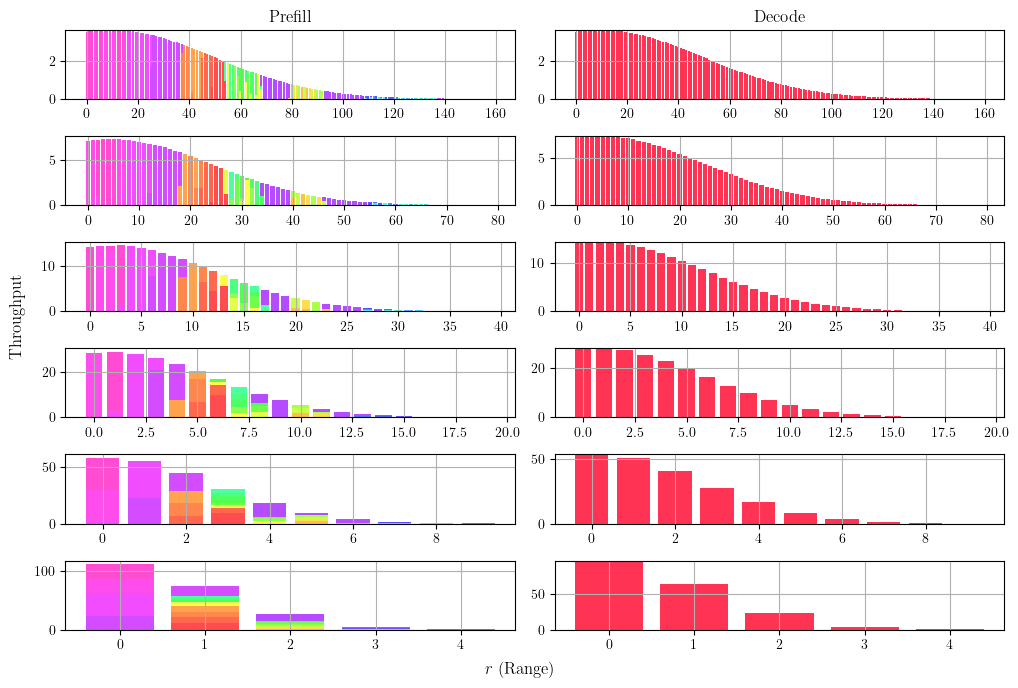

In [35]:
# Create a 4×2 figure (4 rows, 2 columns), with shared x‐ and y‐axes
fig, axes = plt.subplots(6, 2, figsize=(10, 7))

for i, resolution in enumerate(resolutions):
    # 1) Load CSV for this inventory
    assignment_df = pd.read_csv(
        f"../data/inner/eval_{inventory['name']}_res_{resolution}/model_assignment.csv"
    )

    # 2) Build pivot tables for “Prefill_Assignment_Benchmark” and “Decode_Assignment_Benchmark”
    prefill_df = assignment_df.pivot_table(
        index='Range',
        columns='Island',
        values='Prefill_Assignment_Benchmark',
        aggfunc='sum',
        fill_value=0
    )
    decode_df = assignment_df.pivot_table(
        index='Range',
        columns='Island',
        values='Decode_Assignment_Benchmark',
        aggfunc='sum',
        fill_value=0
    )

    # 3) Count islands and reset the color cycle so we have one distinct color per island
    num_islands = len(prefill_df.columns)
    print(f"Number of islands in inventory {inventory['name']}: {num_islands}")
    plt.rcParams['axes.prop_cycle'] = plt.cycler(
        color=plt.cm.gist_rainbow(np.linspace(0, 1, num_islands))
    )

    x = prefill_df.index  # ranges

    # 4a) Plot “Prefill_Assignment_Benchmark” in the left column
    ax_prefill = axes[i, 0]
    bottom = None
    for isl in prefill_df.columns:
        ax_prefill.bar(
            x,
            prefill_df[isl],
            bottom=bottom,
            label=isl,
            alpha=0.7
        )
        bottom = prefill_df[isl] if bottom is None else bottom + prefill_df[isl]
    ax_prefill.grid(True)

    # 4b) Plot “Decode_Assignment_Benchmark” in the right column
    ax_decode = axes[i, 1]
    bottom = None
    for isl in decode_df.columns:
        ax_decode.bar(
            x,
            decode_df[isl],
            bottom=bottom,
            label=isl,
            alpha=0.8
        )
        bottom = decode_df[isl] if bottom is None else bottom + decode_df[isl]
    ax_decode.grid(True)

fig.text(0.5, -0.01, r'$r$ (Range)', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# prefill and decode titles
axes[0, 0].set_title(f"Prefill")
axes[0, 1].set_title(f"Decode")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}""throughput.pdf",bbox_inches='tight')